In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
DATA_DIR = '/home/HDD6TB/datasets/emotions/ABAW/ABAW_8/EMI/'
VIDEO_DIR=DATA_DIR+'raw/'
AUDIO_DIR=DATA_DIR+'audio/'
FRAMES_DIR=DATA_DIR+'frames/'
#FACES_DIR=DATA_DIR+'detected_faces/'
FACES_DIR=DATA_DIR+'face_images/'
TRAIN_LABELS=DATA_DIR+'train_split.csv'
VAL_LABELS=DATA_DIR+'valid_split.csv'

TEST_DATA_DIR = DATA_DIR+'test_data/'
TEST_VIDEO_DIR=TEST_DATA_DIR+'raw/'
TEST_AUDIO_DIR=TEST_DATA_DIR+'audio/'
TEST_FRAMES_DIR=TEST_DATA_DIR+'frames/'
#TEST_FACES_DIR=TEST_DATA_DIR+'detected_faces/'
TEST_FACES_DIR=TEST_DATA_DIR+'face_images/'

In [3]:
import os
from PIL import Image
import cv2
import pathlib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

In [4]:
def get_names(id):
    name = ""
    if id>=0 and id<10:
        name = "0000" + str(id)
    elif id>=10 and id<100:
        name = "000" + str(id)
    elif id>=100 and id<1000:
        name = "00" + str(id)
    elif id>=1000 and id<10000:
        name = "0" + str(id)
    else:
        name = str(id)
    return name

In [5]:
compare_filenames=lambda x: int(os.path.splitext(x)[0])

# Extract frames

In [ ]:
for filename in tqdm(sorted(os.listdir(VIDEO_DIR))):
    frames_dir=os.path.join(FRAMES_DIR,str(os.path.splitext(filename)[0]))
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)
    command = "ffmpeg -r 1 -i " + VIDEO_DIR+str(filename) + " -r 1 '" + frames_dir + "/%04d.jpg'"
    #print(command)
    #break
    os.system(command=command)

 36%|███▋      | 4593/12660 [9:55:13<5:01:20,  2.24s/it]   

In [ ]:
for filename in tqdm(sorted(os.listdir(TEST_VIDEO_DIR))):
    frames_dir=os.path.join(TEST_FRAMES_DIR,str(os.path.splitext(filename)[0]))
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)
    command = "ffmpeg -r 1 -i " + TEST_VIDEO_DIR+str(filename) + " -r 1 '" + frames_dir + "/%04d.jpg'"
    #print(command)
    #break
    os.system(command=command)

 69%|██████▊   | 3143/4586 [9:05:17<4:04:45, 10.18s/it] 

# Extract features

In [9]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

print(f"Torch: {torch.__version__}")
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

Torch: 2.0.1+cu118
True


In [10]:
if True:
    if False:
        model_name='mbf_va_mtl.pt'

        IMG_SIZE=112

        test_transforms = transforms.Compose(
        [
            transforms.Resize((112,112)),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
        ]
        )

        import sys
        sys.path.append("../../../emotiefflib/backbones/")
        import mobilefacenet
    else:
        if False:
            #model_name='affectnet_vggface2_enet2_gmp_smooth.pt'
            model_name='enet_b2_8_best.pt'
            #model_name='enet_b2_7.pt'
            IMG_SIZE=260 #224 #
        else:
            #model_name='affectnet_vggface2_enet0.pt'
            #model_name='affectnet_vggface2_enet0_new.pt'
            #model_name='enet_b0_7.pt'
            #model_name='enet_b0_8_best_afew.pt'
            #model_name='enet_b0_8_best_vgaf.pt'
            model_name='enet_b0_8_va_mtl.pt'
            #model_name='mobilevit_va_mtl.pt'

            IMG_SIZE=224

        #IMG_SIZE=112

        test_transforms = transforms.Compose(
            [
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )
        np_transforms = transforms.Compose(
            [
                transforms.ToPILImage(None),
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
            ]
        )


    print(model_name)
    feature_extractor_model = torch.load('../../../models/affectnet_emotions/'+model_name)

else:
    IMG_SIZE=112
    
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])  
    
    import sys
    DDAMNFN_PATH='/home/avsavchenko/src/distr/DDAMFN'
    sys.path.append(DDAMNFN_PATH)
    from networks.DDAM import DDAMNet

    if True:
        feature_extractor_model = DDAMNet(num_class=8, num_head=2)
        model_name='affectnet8_epoch4_acc0.6462'
    else:
        feature_extractor_model = DDAMNet(num_class=10, num_head=2)
        model_name='affectnet8_epoch9_acc0.642_mtl_2'
    feature_extractor_model.load_state_dict(torch.load(DDAMNFN_PATH+'/checkpoints/'+model_name+'.pth')['model_state_dict'])
    feature_extractor_model.bn=torch.nn.Identity()
    print(model_name)

In [12]:
feature_extractor_model

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [13]:
if False:
    classifier_weights=feature_extractor_model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier[0].bias.cpu().data.numpy()
elif True:
    classifier_weights=feature_extractor_model.classifier.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.classifier.bias.cpu().data.numpy()
elif False:
    classifier_weights=feature_extractor_model.head.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.head.fc.bias.cpu().data.numpy()
else:
    classifier_weights=feature_extractor_model.fc.weight.cpu().data.numpy()
    classifier_bias=feature_extractor_model.fc.bias.cpu().data.numpy()
print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

(10, 1280) [[ 0.00679121  0.09001139  0.0694934  ...  0.10351563 -0.00995514
  -0.17376047]
 [-0.004085   -0.07134113 -0.12164655 ... -0.05029012  0.03059323
   0.08198261]
 [-0.0034241  -0.06510569 -0.00448079 ...  0.04248156 -0.10535879
  -0.00544419]
 ...
 [ 0.07878461 -0.03540913 -0.06665969 ... -0.10314589  0.1332206
  -0.06119434]
 [-0.02409821 -0.00270485  0.00887998 ... -0.00501176  0.01345664
  -0.02131553]
 [-0.04529824 -0.04590099 -0.00950194 ...  0.00753843  0.02128105
  -0.05743075]]
(10,) [-0.03629377 -0.00268708 -0.05411524  0.01482256  0.13788255  0.09921926
 -0.05259513 -0.0124341   0.0816549   0.04621203]


In [14]:
if True:
    feature_extractor_model.classifier=torch.nn.Identity()
elif False:
    feature_extractor_model.head.fc=torch.nn.Identity()
else:
    feature_extractor_model.fc=torch.nn.Identity()
feature_extractor_model=feature_extractor_model.to(device)
feature_extractor_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [15]:
def get_probab(features):
    x=np.dot(features,np.transpose(classifier_weights))+classifier_bias
    return x

In [ ]:
print(test_transforms)
data_dir=FACES_DIR
print(data_dir)

videoname2features,videoname2scores={},{}
for videoname in sorted(os.listdir(data_dir)):
    video_dir=os.path.join(data_dir,videoname)   
    print(videoname)
    X_features,img_names=[],[]
    imgs=[]
    for img_name in sorted(os.listdir(video_dir), key=compare_filenames)[::5]:
        #print(video_dir,img_name)
        img = Image.open(os.path.join(video_dir,img_name))
        img_tensor = test_transforms(img)
        if img.size:
            img_names.append(videoname+'/'+img_name)
            imgs.append(img_tensor)
            if len(imgs)>=64: #96: #48: #32:        
                #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                features=features.data.cpu().numpy()
                #print(features.shape)

                if len(X_features)==0:
                    X_features=features
                else:
                    X_features=np.concatenate((X_features,features),axis=0)
                imgs=[]
    #if videoname=='00002':
    #    break

    if len(imgs)>0:        
        #features,_,_ = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
        features = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
        features=features.data.cpu().numpy()

        if len(X_features)==0:
            X_features=features
        else:
            X_features=np.concatenate((X_features,features),axis=0)

        imgs=[]
    if len(X_features)>0:
        X_scores=get_probab(X_features)
        print(X_features.shape,X_scores.shape)
        videoname2features[videoname]=X_features
        videoname2scores[videoname]=X_scores

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
/home/HDD6TB/datasets/emotions/ABAW/ABAW_6/ERI/detected_faces/


  0%|          | 0/12660 [00:00<?, ?it/s]

In [ ]:
print(X_features.shape,X_scores.shape)

### Save/load features 

In [127]:
import pickle
if False:
    #model_name='enet_b2_8_best'
    #model_name='enet_b0_8_best_vgaf'
    model_name='ddamfnet_8'
    has_va=False
else:
    #model_name='enet_b0_8_va_mtl'
    model_name='mobilevit_va_mtl'
    #model_name='mbf_va'
    #model_name='ddamfnet_mtl'
    has_va=True
    
#MODEL2FEATURES='emi_dict_'+model_name+'.pickle' 

MODEL2FEATURES='emi_'+model_name+'_orig_faces.pickle' 

print(MODEL2FEATURES)

emi_mobilevit_va_mtl_orig_faces.pickle


In [ ]:
if False:
    with open(MODEL2FEATURES, 'wb') as handle:
        pickle.dump([videoname2features,videoname2scores], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [128]:
filename=MODEL2FEATURES
with open(filename, 'rb') as handle:
    videoname2features,videoname2scores=pickle.load(handle)
print(len(videoname2features),videoname2features['00001'].shape,videoname2scores['00001'].shape)

17255 (39, 768) (39, 10)


In [129]:
filename='emi_test_'+model_name+'_orig_faces.pickle'
print(filename)
with open(filename, 'rb') as handle:
    videoname2features_test,videoname2scores_test=pickle.load(handle)
print(len(videoname2features_test),videoname2features_test['12660'].shape,videoname2scores_test['12660'].shape)

emi_test_mobilevit_va_mtl_orig_faces.pickle
4586 (39, 768) (39, 10)


### Audio

In [8]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model,AutoProcessor, HubertModel
import torchaudio
import torch

In [9]:
if False:
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
    model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
else:
    processor = AutoProcessor.from_pretrained("facebook/hubert-large-ls960-ft")
    model = HubertModel.from_pretrained("facebook/hubert-large-ls960-ft")
model.eval()

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertLayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x HubertLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=

In [12]:
#videoname2audio_features={}
for filename in tqdm(sorted(os.listdir(AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    #print(videoname)
    if videoname in videoname2audio_features:
        continue
    array, fs = torchaudio.load(os.path.join(AUDIO_DIR,filename))
    inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inp)
    videoname2audio_features[videoname]=outputs.last_hidden_state.numpy()[0]
    #print(videoname2audio_features[videoname].shape)

100%|██████████| 12660/12660 [06:22<00:00, 33.13it/s]   


In [9]:
#MODEL2AUDIOFEATURES='emi_dict_wav2vec2.pickle'
MODEL2AUDIOFEATURES='emi_dict_hubert.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(videoname2audio_features, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        videoname2audio_features=pickle.load(handle)
print(len(videoname2audio_features),videoname2audio_features['00001'].shape)

12660 (306, 1024)


In [ ]:
import wave, struct
from fnmatch import fnmatch
for filename in tqdm(os.listdir(TEST_VIDEO_DIR)):
    #print(filename)
    video_path=os.path.join(TEST_VIDEO_DIR,filename)
    fn=os.path.splitext(filename)[0]
    waveFile = os.path.join(TEST_AUDIO_DIR, fn+'.wav')
    command = "ffmpeg -i "+video_path+" -ac 1 -ar 16000 -vn "+waveFile
    #print(command)
    os.system(command=command)

In [14]:
videoname2audio_features_test={}
for filename in tqdm(sorted(os.listdir(TEST_AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    if videoname in videoname2audio_features_test:
        continue
    array, fs = torchaudio.load(os.path.join(TEST_AUDIO_DIR,filename))
    inp = processor(array.squeeze(), sampling_rate=fs, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inp)
    videoname2audio_features_test[videoname]=outputs.last_hidden_state.numpy()[0]
    #print(videoname,videoname2audio_features_test[videoname].shape)

100%|██████████| 4586/4586 [00:00<00:00, 352426.36it/s]


In [10]:
#MODEL2AUDIOFEATURES='emi_test_wav2vec2.pickle'
MODEL2AUDIOFEATURES='emi_test_hubert.pickle'

if False:
    with open(MODEL2AUDIOFEATURES, 'wb') as handle:
        pickle.dump(videoname2audio_features_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(MODEL2AUDIOFEATURES, 'rb') as handle:
        videoname2audio_features_test=pickle.load(handle)
print(len(videoname2audio_features_test),videoname2audio_features_test['12660'].shape)

4586 (305, 1024)


### Speech2text 

In [15]:
import whisper

model = whisper.load_model("small.en")

In [7]:
result = model.transcribe(os.path.join(AUDIO_DIR,'00000.mp3'))
print(result,result["text"])

{'text': " My whole family, you know, it's my team. I'm a huge Patriots fan, so.", 'segments': [{'id': 0, 'seek': 0, 'start': 0.0, 'end': 3.2, 'text': " My whole family, you know, it's my team.", 'tokens': [50363, 2011, 2187, 1641, 11, 345, 760, 11, 340, 338, 616, 1074, 13, 50523], 'temperature': 0.0, 'avg_logprob': -0.399750306056096, 'compression_ratio': 0.9324324324324325, 'no_speech_prob': 0.052879199385643005}, {'id': 1, 'seek': 0, 'start': 3.2, 'end': 5.6000000000000005, 'text': " I'm a huge Patriots fan, so.", 'tokens': [50523, 314, 1101, 257, 3236, 13104, 4336, 11, 523, 13, 50643], 'temperature': 0.0, 'avg_logprob': -0.399750306056096, 'compression_ratio': 0.9324324324324325, 'no_speech_prob': 0.052879199385643005}], 'language': 'en'}  My whole family, you know, it's my team. I'm a huge Patriots fan, so.


In [81]:
videoname2text={}
for filename in tqdm(sorted(os.listdir(AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    #print(videoname)
    result = model.transcribe(os.path.join(AUDIO_DIR,filename))
    videoname2text[videoname]=result["text"]
    if videoname2text[videoname]=='':
        print(filename)
    #print(videoname2features[videoname].shape)

  0%|          | 0/12660 [00:00<?, ?it/s]


NameError: name 'model' is not defined

In [11]:
AUDIO2TEXTS='emi_whisper.pickle'

if False:
    with open(AUDIO2TEXTS, 'wb') as handle:
        pickle.dump(videoname2text, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXTS, 'rb') as handle:
        videoname2text=pickle.load(handle)
print(len(videoname2text),videoname2text['12659'])

12660  See what he decides to do. If he decides to not make the weight or make the weight, see what happens.


In [49]:
print(len(videoname2text),videoname2text['00001'])

12660  I'm never going to be taking it on.


---------------

In [17]:
videoname2text_test={}
for filename in tqdm(sorted(os.listdir(TEST_AUDIO_DIR))):
    videoname,_=os.path.splitext(filename)
    #print(videoname)
    result = model.transcribe(os.path.join(TEST_AUDIO_DIR,filename))
    videoname2text_test[videoname]=result["text"]
    if videoname2text_test[videoname]=='':
        print(filename)
    #print(videoname2text_test[videoname].shape)

  0%|          | 13/4586 [00:07<40:11,  1.90it/s]

12672.wav


  2%|▏         | 76/4586 [00:42<38:07,  1.97it/s]

12735.wav


  4%|▎         | 167/4586 [01:36<39:25,  1.87it/s]

12826.wav


  8%|▊         | 376/4586 [03:37<35:37,  1.97it/s]

13035.wav


 15%|█▌        | 691/4586 [06:39<35:26,  1.83it/s]

13350.wav


 18%|█▊        | 807/4586 [07:47<34:33,  1.82it/s]

13466.wav


 19%|█▉        | 861/4586 [08:19<33:31,  1.85it/s]

13520.wav


 21%|██        | 970/4586 [09:25<30:31,  1.97it/s]  

13629.wav


 23%|██▎       | 1040/4586 [10:10<31:53,  1.85it/s] 

13699.wav


 24%|██▍       | 1100/4586 [10:46<32:27,  1.79it/s]

13759.wav


 25%|██▍       | 1134/4586 [11:06<32:48,  1.75it/s]

13793.wav


 25%|██▌       | 1150/4586 [11:15<31:02,  1.84it/s]

13809.wav


 26%|██▌       | 1191/4586 [11:38<28:31,  1.98it/s]

13850.wav


 26%|██▌       | 1193/4586 [11:40<28:33,  1.98it/s]

13852.wav


 29%|██▉       | 1347/4586 [13:11<26:14,  2.06it/s]

14006.wav


 31%|███▏      | 1437/4586 [14:02<26:46,  1.96it/s]

14096.wav


 33%|███▎      | 1524/4586 [15:02<27:18,  1.87it/s]  

14183.wav


 37%|███▋      | 1688/4586 [16:39<27:26,  1.76it/s]

14347.wav


 37%|███▋      | 1713/4586 [16:53<24:40,  1.94it/s]

14372.wav


 40%|███▉      | 1834/4586 [18:07<22:44,  2.02it/s]  

14493.wav


 42%|████▏     | 1920/4586 [19:02<23:44,  1.87it/s]  

14579.wav


 43%|████▎     | 1950/4586 [19:20<25:29,  1.72it/s]

14609.wav


 43%|████▎     | 1972/4586 [19:32<22:55,  1.90it/s]

14631.wav


 43%|████▎     | 1993/4586 [19:44<21:27,  2.01it/s]

14652.wav


 47%|████▋     | 2153/4586 [21:19<20:11,  2.01it/s]

14812.wav


 48%|████▊     | 2181/4586 [21:36<21:32,  1.86it/s]

14840.wav


 48%|████▊     | 2194/4586 [21:44<20:44,  1.92it/s]

14853.wav


 50%|████▉     | 2271/4586 [22:34<21:07,  1.83it/s]  

14930.wav


 50%|████▉     | 2282/4586 [22:41<20:00,  1.92it/s]

14941.wav


 50%|█████     | 2300/4586 [22:51<19:20,  1.97it/s]

14959.wav


 51%|█████     | 2334/4586 [23:10<18:57,  1.98it/s]

14993.wav


 54%|█████▍    | 2491/4586 [24:46<18:22,  1.90it/s]

15150.wav


 55%|█████▍    | 2503/4586 [24:57<25:18,  1.37it/s]

15162.wav


 56%|█████▌    | 2548/4586 [25:23<15:58,  2.13it/s]

15207.wav


 59%|█████▉    | 2707/4586 [26:55<15:31,  2.02it/s]

15366.wav


 61%|██████    | 2785/4586 [27:43<15:04,  1.99it/s]

15444.wav


 61%|██████    | 2786/4586 [27:43<14:11,  2.11it/s]

15445.wav


 61%|██████    | 2787/4586 [27:43<13:27,  2.23it/s]

15446.wav


 62%|██████▏   | 2842/4586 [28:16<14:36,  1.99it/s]

15501.wav


 62%|██████▏   | 2857/4586 [28:24<14:28,  1.99it/s]

15516.wav


 63%|██████▎   | 2878/4586 [28:35<13:44,  2.07it/s]

15537.wav


 63%|██████▎   | 2883/4586 [28:37<13:30,  2.10it/s]

15542.wav


 65%|██████▌   | 2995/4586 [29:43<13:39,  1.94it/s]

15654.wav


 71%|███████   | 3267/4586 [32:17<10:59,  2.00it/s]

15926.wav


 74%|███████▍  | 3406/4586 [33:41<09:59,  1.97it/s]

16065.wav


 75%|███████▍  | 3423/4586 [33:50<09:12,  2.10it/s]

16082.wav


 76%|███████▋  | 3506/4586 [34:38<09:46,  1.84it/s]

16165.wav


 77%|███████▋  | 3533/4586 [34:53<09:30,  1.84it/s]

16192.wav


 78%|███████▊  | 3593/4586 [35:27<08:36,  1.92it/s]

16252.wav


 79%|███████▉  | 3641/4586 [35:54<08:13,  1.92it/s]

16300.wav


 80%|███████▉  | 3667/4586 [36:10<07:43,  1.98it/s]

16326.wav


 81%|████████  | 3708/4586 [36:33<07:12,  2.03it/s]

16367.wav


 82%|████████▏ | 3780/4586 [37:16<07:13,  1.86it/s]

16439.wav


 82%|████████▏ | 3782/4586 [37:17<06:27,  2.07it/s]

16441.wav


 83%|████████▎ | 3789/4586 [37:20<06:47,  1.95it/s]

16448.wav


 84%|████████▎ | 3833/4586 [37:46<06:28,  1.94it/s]

16492.wav


 92%|█████████▏| 4206/4586 [41:23<03:07,  2.03it/s]

16865.wav


 93%|█████████▎| 4269/4586 [42:00<02:50,  1.86it/s]

16928.wav


 95%|█████████▍| 4351/4586 [42:48<01:57,  2.00it/s]

17010.wav


 96%|█████████▌| 4409/4586 [43:22<01:26,  2.04it/s]

17068.wav


 97%|█████████▋| 4462/4586 [43:54<01:04,  1.92it/s]

17121.wav


 98%|█████████▊| 4506/4586 [44:19<00:41,  1.91it/s]

17165.wav


 99%|█████████▊| 4524/4586 [44:29<00:34,  1.81it/s]

17183.wav


 99%|█████████▉| 4548/4586 [44:45<00:19,  1.99it/s]

17207.wav


100%|██████████| 4586/4586 [45:07<00:00,  1.69it/s]


In [12]:
AUDIO2TEXTS_TEST='test_emi_whisper.pickle'

if False:
    with open(AUDIO2TEXTS_TEST, 'wb') as handle:
        pickle.dump(videoname2text_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXTS_TEST, 'rb') as handle:
        videoname2text_test=pickle.load(handle)
print(len(videoname2text_test),videoname2text_test['12660'])

4586  The best part of the day was to watch her up there. She came back to give me a hug and I...


#### Feature extraction 

In [14]:
from transformers import pipeline
model_path="SamLowe/roberta-base-go_emotions"
classifier = pipeline(task="feature-extraction", model=model_path, tokenizer=model_path, max_length=512, truncation=True)


Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
sentences = [videoname2text['00000'],videoname2text['00001']]

output=classifier(sentences, return_tensors="pt")
print(output)

[tensor([[[-0.6626, -0.0111, -0.6688,  ..., -0.1648, -0.2732, -0.4058],
         [-0.7530,  0.2160, -0.8748,  ...,  0.0453, -0.3357, -0.7738],
         [-0.7656,  0.0517, -0.7858,  ..., -0.0673, -0.3087, -0.5945],
         ...,
         [-0.5023,  0.0359, -0.7933,  ..., -0.2363, -0.3283, -0.5064],
         [-0.6735,  0.1548, -0.5454,  ..., -0.1347, -0.1967, -0.7317],
         [-0.7442,  0.0533, -0.7956,  ..., -0.0215, -0.3060, -0.4393]]]), tensor([[[-0.5198,  0.9053, -0.1771,  ..., -0.0179, -0.2662, -0.5434],
         [-0.5071,  0.9350, -0.1965,  ...,  0.1282, -0.2558, -0.6599],
         [-0.6546,  1.1305, -0.2201,  ..., -0.0175, -0.2161, -0.5269],
         ...,
         [-0.5976,  0.8133, -0.0179,  ..., -0.1762, -0.3943, -0.3269],
         [-0.4429,  0.7702, -0.2875,  ...,  0.3837, -0.3819, -0.6284],
         [-0.4844,  0.8901, -0.2096,  ...,  0.1222, -0.3600, -0.4821]]])]


In [84]:
text_embeddings_list=[]
sentences=[]
for videoname in tqdm(videoname2text):
    sentences.append(videoname2text[videoname])
    if len(sentences)>32:
        outputs=classifier(sentences, return_tensors="pt")
        for output in outputs:
            text_embeddings_list.append(output[0].numpy())
        sentences=[]
        #break
if len(sentences)>0:
    outputs=classifier(sentences, return_tensors="pt")
    for output in outputs:
        text_embeddings_list.append(output[0].numpy())
    sentences=[]

100%|██████████| 12660/12660 [04:11<00:00, 50.36it/s]


In [54]:
from sentence_transformers import SentenceTransformer
#model_name='distilroberta-base'
#model_name='all-MiniLM-L6-v1'
model_name='intfloat/e5-base-v2'
model_st = SentenceTransformer(model_name)

No sentence-transformers model found with name SamLowe/roberta-base-go_emotions. Creating a new one with mean pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
text_embeddings_list=[]
sentences=[]
for videoname in tqdm(videoname2text):
    sentences.append(videoname2text[videoname])
    if len(sentences)>32:
        outputs=model_st.encode(sentences)
        for output in outputs:
            text_embeddings_list.append(output)
        sentences=[]
        #break
if len(sentences)>0:
    outputs=model_st.encode(sentences)
    for output in outputs:
        text_embeddings_list.append(output)
    sentences=[]
#print(text_embeddings_list[0].shape,text_embeddings_list[1].shape)

100%|██████████| 12660/12660 [00:19<00:00, 661.53it/s]


In [85]:
#text_embeddings_list[2].shape
text_embeddings={}
for i,videoname in enumerate(videoname2text):
    text_embeddings[videoname]=text_embeddings_list[i]

In [140]:
#AUDIO2TEXT_EMBEDDINGS='emi_whisper_roberta-base-go_emotions.pickle'
#AUDIO2TEXT_EMBEDDINGS='emi_whisper_distilroberta.pickle'
#AUDIO2TEXT_EMBEDDINGS='emi_whisper_e5.pickle'
AUDIO2TEXT_EMBEDDINGS='emi_whisper_openai_small.pickle'
#AUDIO2TEXT_EMBEDDINGS='emi_whisper_gigachat.pickle'

if False:
    with open(AUDIO2TEXT_EMBEDDINGS, 'wb') as handle:
        pickle.dump(text_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXT_EMBEDDINGS, 'rb') as handle:
        text_embeddings=pickle.load(handle)
print(len(text_embeddings),text_embeddings['12659'].shape)

12660 (1536,)


In [141]:
videoname2text_features={}
for videoname in text_embeddings:
    embs_all=text_embeddings[videoname]
    #videoname2text_features[videoname]=embs_all[:1]
    if len(embs_all.shape)>1:
        videoname2text_features[videoname]=embs_all
    else:
        videoname2text_features[videoname]=np.reshape(embs_all,(1,-1))

-----

In [17]:
text_embeddings_test_list=[]
sentences=[]
for videoname in tqdm(videoname2text_test):
    sentences.append(videoname2text_test[videoname])
    if len(sentences)>32:
        outputs=classifier(sentences, return_tensors="pt")
        for output in outputs:
            text_embeddings_test_list.append(output[0].numpy())
        sentences=[]
        #break
if len(sentences)>0:
    outputs=classifier(sentences, return_tensors="pt")
    for output in outputs:
        text_embeddings_test_list.append(output[0].numpy())
    sentences=[]
    
text_embeddings_test={}
for i,videoname in enumerate(videoname2text_test):
    text_embeddings_test[videoname]=text_embeddings_test_list[i]

100%|██████████| 4586/4586 [01:29<00:00, 51.08it/s]


In [142]:
#AUDIO2TEXT_EMBEDDINGS_TEST='test_emi_whisper_roberta-base-go_emotions.pickle'
AUDIO2TEXT_EMBEDDINGS_TEST='test_emi_whisper_openai_small.pickle'
#AUDIO2TEXT_EMBEDDINGS_TEST='test_emi_whisper_gigachat.pickle'

if False:
    with open(AUDIO2TEXT_EMBEDDINGS_TEST, 'wb') as handle:
        pickle.dump(text_embeddings_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(AUDIO2TEXT_EMBEDDINGS_TEST, 'rb') as handle:
        text_embeddings_test=pickle.load(handle)
print(len(text_embeddings_test),text_embeddings_test['12660'].shape)

4586 (1536,)


In [143]:
videoname2text_features_test={}
for videoname in text_embeddings_test:
    embs_all=text_embeddings_test[videoname]
    #videoname2text_features_test[videoname]=embs_all[:1]
    if len(embs_all.shape)>1:
        videoname2text_features_test[videoname]=embs_all
    else:
        videoname2text_features_test[videoname]=np.reshape(embs_all,(1,-1))

# Preprocess data

In [144]:
def get_video2targets(videoname2features,filename,stat=False):
    num_missed=0
    X,y=[],[]
    with open(os.path.join(DATA_DIR,filename)) as f:
        lines = f.read().splitlines()
        for i,line in enumerate(lines):
            if i>0:
                splitted_line=line.split(',')
                videoname=splitted_line[0]
                if videoname in videoname2features:
                    features=videoname2features[videoname]

                    mean_features=features.mean(axis=0)
                    std_features=features.std(axis=0)
                    min_features=features.min(axis=0)
                    max_features=features.max(axis=0)
                    
                    if stat:
                        aggregated_feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)
                    else:
                        aggregated_feature=mean_features

                    X.append(aggregated_feature)

                    targets=[float(s) for s in splitted_line[1:]]
                    y.append(targets)
                else:
                    num_missed+=1
                    print('Missed:',videoname)
        X=np.array(X)
        y=np.array(y)
        print(X.shape,y.shape,num_missed)
        return X,y

if False:
    X_train,y_train=get_video2targets(videoname2scores,TRAIN_LABELS,True)
    X_val,y_val=get_video2targets(videoname2scores,VAL_LABELS,True)
elif False:
    #Audio
    X_train,y_train=get_video2targets(videoname2audio_features,TRAIN_LABELS)
    X_val,y_val=get_video2targets(videoname2audio_features,VAL_LABELS)
else:
    #texts
    X_train,y_train=get_video2targets(videoname2text_features,TRAIN_LABELS)
    X_val,y_val=get_video2targets(videoname2text_features,VAL_LABELS)

TRAIN_VAL=False

(8072, 1536) (8072, 6) 0
(4588, 1536) (4588, 6) 0


In [56]:
def get_concat_features2targets(videoname2features,filename):
    num_missed=0
    X,y=[],[]
    with open(os.path.join(DATA_DIR,filename)) as f:
        lines = f.read().splitlines()
        for i,line in enumerate(lines):
            if i>0:
                splitted_line=line.split(',')
                videoname=splitted_line[0]
                if videoname in videoname2features:
                    features=videoname2features[videoname]
                    mean_features=features.mean(axis=0)
                    std_features=features.std(axis=0)
                    min_features=features.min(axis=0)
                    max_features=features.max(axis=0)
                    
                    visual_features = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)
                    #visual_features=mean_features
                    
                    audio_features=videoname2audio_features[videoname].mean(axis=0)
                    text_features=videoname2text_features[videoname].mean(axis=0)
                    #aggregated_feature = np.concatenate((visual_features,audio_features,text_features), axis=None)
                    #aggregated_feature = np.concatenate((visual_features,text_features), axis=None)
                    aggregated_feature = np.concatenate((audio_features,text_features), axis=None)

                    X.append(aggregated_feature)

                    targets=[float(s) for s in splitted_line[1:]]
                    y.append(targets)
                else:
                    num_missed+=1
                    print('Missed:',videoname)
        X=np.array(X)
        y=np.array(y)
        print(X.shape,y.shape,num_missed)
        return X,y
    
X_val,y_val=get_concat_features2targets(videoname2scores,TRAIN_LABELS)
X_train,y_train=get_concat_features2targets(videoname2scores,VAL_LABELS)
TRAIN_VAL=False

(8072, 2048) (8072, 6) 0
(4588, 2048) (4588, 6) 0


In [122]:
if True:
    TRAIN_VAL=True
    X_train=np.concatenate((X_train,X_val))
    y_train=np.concatenate((y_train,y_val))
    print(X_train.shape,y_train.shape)

(12660, 1024) (12660, 6)


In [18]:
classes=['Admiration','Amusement','Determination','Empathic Pain','Excitement','Joy']
num_classes=len(classes)
print(classes,num_classes)

['Admiration', 'Amusement', 'Determination', 'Empathic Pain', 'Excitement', 'Joy'] 6


<Figure size 216x216 with 0 Axes>

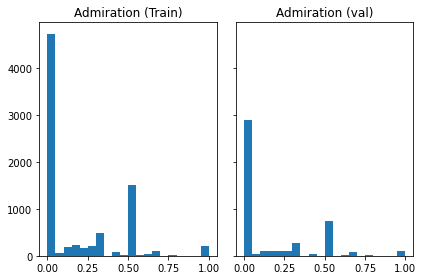

<Figure size 216x216 with 0 Axes>

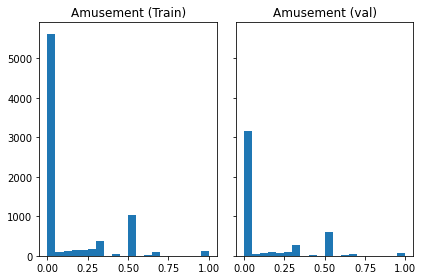

<Figure size 216x216 with 0 Axes>

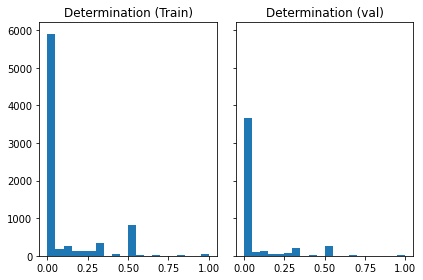

<Figure size 216x216 with 0 Axes>

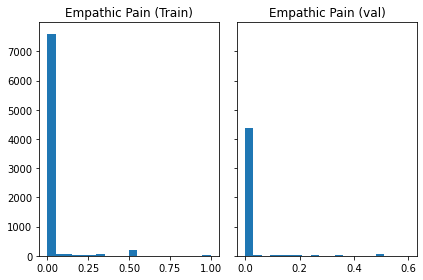

<Figure size 216x216 with 0 Axes>

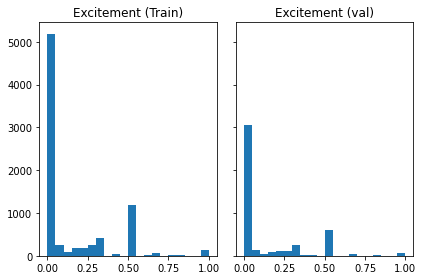

<Figure size 216x216 with 0 Axes>

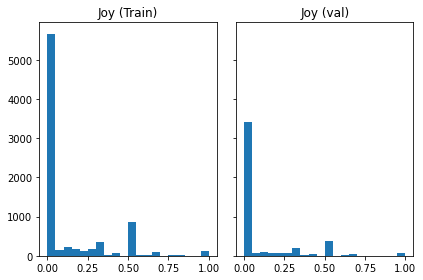

In [22]:
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_train[:,i], bins=20)
    axs[0].set_title(cls+' (Train)')
    axs[1].hist(y_val[:,i], bins=20)
    axs[1].set_title(cls+' (val)')

# Learning

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,vgg16,resnet_v2,resnet
import efficientnet.tfkeras as enet
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras.backend as K 

print(tf.__version__)
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2.13.1


In [20]:
from copy import deepcopy
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_model_weights = deepcopy(self.model.get_weights())

In [21]:
def CCC_score(x, y):
    vx = x - np.mean(x)
    vy = y - np.mean(y)
    rho = np.sum(vx * vy) / (np.sqrt(np.sum(vx**2)) * np.sqrt(np.sum(vy**2)))
    x_m = np.mean(x)
    y_m = np.mean(y)
    x_s = np.std(x)
    y_s = np.std(y)
    ccc = 2*rho*x_s*y_s/(x_s**2 + y_s**2 + (x_m - y_m)**2)
    return ccc


def CCC_numpy(y_true, y_pred):
    '''Reference numpy implementation of Lin's Concordance correlation coefficient'''
    
    # covariance between y_true and y_pred
    s_xy = np.cov([y_true, y_pred])[0,1]
    # means
    x_m = np.mean(y_true)
    y_m = np.mean(y_pred)
    # variances
    s_x_sq = np.var(y_true)
    s_y_sq = np.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2)
    
    return ccc

def CCC(y_true, y_pred):
    '''Lin's Concordance correlation coefficient: https://en.wikipedia.org/wiki/Concordance_correlation_coefficient
    
    The concordance correlation coefficient is the correlation between two variables that fall on the 45 degree line through the origin.
    
    It is a product of
    - precision (Pearson correlation coefficient) and
    - accuracy (closeness to 45 degree line)

    Interpretation:
    - `rho_c =  1` : perfect agreement
    - `rho_c =  0` : no agreement
    - `rho_c = -1` : perfect disagreement 
    
    Args: 
    - y_true: ground truth
    - y_pred: predicted values
    
    Returns:
    - concordance correlation coefficient (float)
    '''
    
    
    # covariance between y_true and y_pred
    #N = K.int_shape(y_pred)[-1]
    #s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    #s_xy = K.mean(K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred))))
    s_xy = K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # means
    x_m = K.mean(y_true)
    y_m = K.mean(y_pred)
    # variances
    s_x_sq = K.var(y_true)
    s_y_sq = K.var(y_pred)
    
    # condordance correlation coefficient
    ccc = (2.0*s_xy) / (s_x_sq + s_y_sq + (x_m-y_m)**2+K.epsilon())
    #print(s_xy,s_x_sq,s_y_sq,x_m,y_m)
    return ccc

def CCC_EMI(y_true, y_pred):
    loss=0
    #print(y_true.shape,y_pred.shape)
    for i in range(num_classes):
        loss+=CCC(y_true[:,i], y_pred[:,i])
    return 1-loss/num_classes

from scipy import stats 
import numpy as np

def calc_pearsons(preds,labels):
    r = stats.pearsonr(preds, labels)
    return r[0]

def mean_pearsons(preds,labels):
    preds = np.row_stack([np.array(p) for p in preds])
    labels = np.row_stack([np.array(l) for l in labels])
    num_classes = preds.shape[1]
    class_wise_r = np.array([calc_pearsons(preds[:,i], labels[:,i]) for i in range(num_classes)])
    mean_r = np.mean(class_wise_r)
    return mean_r, class_wise_r

In [22]:
#counts=np.array([0.04752795, 0.25179336, 0.12408552, 0.08759098, 0.24792852, 0.28702279])
counts=np.array([1, 8, 4, 2, 8, 8])
class_weights=1/counts
class_weights/=class_weights.sum()
class_weights_sum=class_weights.sum()
print(class_weights,class_weights_sum)

[0.47058824 0.05882353 0.11764706 0.23529412 0.05882353 0.05882353] 1.0


In [23]:
def Pearson(y_true, y_pred):
    # covariance between y_true and y_pred
    #N = K.int_shape(y_pred)[-1]
    #s_xy = 1.0 / (N - 1.0 + K.epsilon()) * K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    #s_xy = K.mean(K.sum((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred))))
    s_xy = K.mean((y_true - K.mean(y_true)) * (y_pred - K.mean(y_pred)))
    # variances
    s_x_sq = K.std(y_true)
    s_y_sq = K.std(y_pred)
    
    # pearson correlation coefficient
    pcc = (s_xy) / (s_x_sq * s_y_sq + K.epsilon())
    return pcc

def Pearson_EMI_loss(y_true, y_pred):
    loss=0
    #print(y_true.shape,y_pred.shape)
    for i in range(y_true.shape[1]):
        loss+=Pearson(y_true[:,i], y_pred[:,i])# *class_weights[i]
    return 1-loss/y_true.shape[1]#+0.1*K.binary_crossentropy(y_true, y_pred)

def Pearson_EMI_loss_weighted(y_true, y_pred):
    loss=0
    for i in range(y_true.shape[1]):
        loss+=Pearson(y_true[:,i], y_pred[:,i]) *class_weights[i]
    return 1-loss


def ProdLoss(y_true, y_pred):
    return K.mean(y_true  * y_pred)

def Prod_EMI_loss(y_true, y_pred):
    loss=0
    for i in range(y_true.shape[1]):
        loss+=ProdLoss(y_true[:,i], y_pred[:,i]) *class_weights[i]
    return 1-loss/y_true.shape[1]

def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return r_num / r_den

def pearson_correlation(y_true, y_pred):
    r=0
    for i in range(y_true.shape[1]):
        r+=correlation(y_true[:,i], y_pred[:,i])
    return r/y_true.shape[1]


In [24]:
def print_metrics():
    y_val_preds=mlpModel.predict(X_val,verbose=0)
    print(mean_pearsons(y_val_preds,y_val))

In [25]:
if True:
    loss='binary_crossentropy'
    #loss='hinge'
else:
    import tensorflow.keras.backend as K
    def get_weighted_loss(weights):
        def weighted_loss(y_true, y_pred):
            y_true=tf.cast(y_true, tf.float32)
            ce=K.binary_crossentropy(y_true, y_pred)
            return K.mean((weights[:,0]**(1-y_true))*(weights[:,1]**(y_true))*ce, axis=-1)
        return weighted_loss
    loss=get_weighted_loss(class_weights)

In [145]:
batch_size=512 #128 #1024 #
mlpModel=Sequential()
mlpModel.add(Dense(64, input_shape=X_train.shape[1:],activation='relu'))
#mlpModel.add(Dense(256, input_shape=X_train.shape[1:],activation='relu'))
mlpModel.add(Dense(num_classes,activation='sigmoid'))
    
mlpModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=Pearson_EMI_loss_weighted, metrics=[pearson_correlation])
mlpModel.summary()

import gc
gc.collect()

#save_best_model = SaveBestModel('val_loss',False)
save_best_model = SaveBestModel('val_pearson_correlation',True)

num_epochs=20
#num_epochs=5

mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_metrics()
if not TRAIN_VAL:
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
    print_metrics()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 64)                98368     
                                                                 
 dense_36 (Dense)            (None, 6)                 390       
                                                                 
Total params: 98758 (385.77 KB)
Trainable params: 98758 (385.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
16/16 [==============================] - 2s 32ms/step - loss: 0.6716 - pearson_correlation: 0.2385 - val_loss: 0.5968 - val_pearson_correlation: 0.3219
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5065 - pearson_correlation: 0.4213 - val_loss: 0.5627 - val_pearson_correlation: 0.3685
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 0.4624 - pea

In [123]:
batch_size=512 #128 #1024 #
mlpModel=Sequential()

#mlpModel.add(Dense(num_classes, input_shape=X_train.shape[1:],activation='tanh',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
mlpModel.add(Dense(num_classes, input_shape=X_train.shape[1:],activation='sigmoid',use_bias=True,kernel_regularizer=tf.keras.regularizers.l2(1.0/batch_size)))
    
mlpModel.compile(optimizer=Adam(learning_rate=1e-3), loss=Pearson_EMI_loss, metrics=[pearson_correlation])

mlpModel.summary()

import gc
gc.collect()

#save_best_model = SaveBestModel('val_loss',False)
save_best_model = SaveBestModel('val_pearson_correlation',True)

num_epochs=100
#num_epochs=10

mlpModel.fit(X_train,y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[save_best_model], validation_data=(X_val,y_val))
best_model_weights = save_best_model.best_model_weights
print(save_best_model.best)

print_metrics()
if not TRAIN_VAL:
    print('Best weights:')
    mlpModel.set_weights(best_model_weights)
    print_metrics()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 6)                 6150      
                                                                 
Total params: 6150 (24.02 KB)
Trainable params: 6150 (24.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
25/25 [==============================] - 2s 22ms/step - loss: 0.8135 - pearson_correlation: 0.2110 - val_loss: 0.6951 - val_pearson_correlation: 0.3285
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 0.6472 - pearson_correlation: 0.3768 - val_loss: 0.6395 - val_pearson_correlation: 0.3842
Epoch 3/10
25/25 [==============================] - 0s 12ms/step - loss: 0.6072 - pearson_correlation: 0.4161 - val_loss: 0.6131 - val_pearson_correlation: 0.4099
Epoch 4/10
25/25 [==============================] - 0s 13m

In [43]:
y_val_preds=mlpModel.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds,y_val))
def correlation_np(x, y):    
    mx = np.mean(x)
    my = np.mean(y)
    xm, ym = x-mx, y-my
    r_num = np.mean(np.multiply(xm,ym))        
    r_den = np.std(xm) * np.std(ym)
    return r_num / r_den
print(correlation_np(y_val_preds,y_val))

(0.3036114177130423, array([0.36225626, 0.31950403, 0.28417176, 0.31438462, 0.28659277,
       0.25475907]))
0.250325135884467


In [38]:
if True:
    #mlpModel.save_weights('emi_mbf_va_face_images.h5')#0.181732535711447
    #mlpModel.save_weights('emi_mobilevit_va_face_images.h5')#0.174064572542725
    #mlpModel.save_weights('emi_audio_hubert.h5')#0.30440993311983106
    #mlpModel.save_weights('emi_text_gigachat.h5')#logreg: 0.4001222448307076
    #mlpModel.save_weights('emi_text_openai.h5')#1 layer: 0.3947932220697352
    #mlpModel.save_weights('emi_text_openai_new.h5') #0.40139028171239866
    #mlpModel.save_weights('emi_text_roberta.h5')#1 layer: 0.3764463318563458
else:
    #mlpModel.load_weights('emi_audio.h5')
    mlpModel.load_weights('emi_mobilevit_va_face_images.h5') #0.17645105962016794
    #mlpModel.load_weights('emi_mbf_va_face_images.h5')
    print_metrics()

In [135]:
mlpModelFace=mlpModel
#mlpModelFace.load_weights('emi_mbf_va_face_images.h5') #0 layers, all epochs
mlpModel.load_weights('emi_mobilevit_va_face_images.h5') #1 layer, all epochs
y_val_preds_video=mlpModelFace.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds_video,y_val))

(0.17645105962016794, array([0.05056633, 0.26280262, 0.13856302, 0.0857433 , 0.24313548,
       0.27789561]))


In [79]:
mlpModelAudio=mlpModel
mlpModelAudio.load_weights('emi_audio_hubert.h5') # 0 layers, all epochs
y_val_preds_audio=mlpModelAudio.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds_audio,y_val))

(0.30440993311983106, array([0.35629425, 0.32200886, 0.29701485, 0.30874692, 0.28921052,
       0.2531842 ]))


In [146]:
mlpModelText=mlpModel
#mlpModelText.load_weights('emi_text_roberta.h5') #1 layer 20 epochs
mlpModelText.load_weights('emi_text_openai_new.h5') # 1 layer 5 epochs
#mlpModelText.load_weights('emi_text_gigachat.h5') # 0 layers 10 epochs
y_val_preds_text=mlpModelText.predict(X_val,verbose=0)
print(mean_pearsons(y_val_preds_text,y_val))

(0.40139028171239866, array([0.50693966, 0.38156038, 0.36729544, 0.48815603, 0.34613742,
       0.31825276]))


In [124]:
if True:
    #mlpModelFace=mlpModel
    #mlpModelFace.save_weights('test_mbf_va_face_images.h5') 
    #mlpModelFace.save_weights('test_mobilevit_va_face_images.h5') 
    
    #mlpModelAudio.save_weights('test_audio_hubert.h5') 
    
    mlpModelText=mlpModel
    #mlpModelText.save_weights('test_emi_text_roberta.h5') 
    #mlpModelText.save_weights('test_emi_text_openai.h5') 
    mlpModelText.save_weights('test_emi_text_gigachat.h5') 


best_vgaf
features: 0.16468719325142459, array([0.04719238, 0.23872681, 0.12715181, 0.10167664, 0.22254081,
       0.25083472])
agg features: 0.16581090507195018, array([0.05959792, 0.2307677 , 0.13180669, 0.07433949, 0.23725057,
       0.26110306])
scores: 0.15956704687617598, array([0.01631927, 0.23423282, 0.13149749, 0.07082677, 0.22806896,
       0.27645697])
agg scores: 0.16445071167985162, array([0.01858242, 0.24766241, 0.12774497, 0.07869363, 0.22775766,
       0.28626319])

       
mbf_va
features:0.15182967597822564, array([0.02151467, 0.22876023, 0.11397221, 0.0691848 , 0.22993618,
       0.24760996])
aggregate all features: 0.1645556550825007, array([0.05571004, 0.23802543, 0.13028415, 0.07030688, 0.23254514,
       0.26046229])
       
scores:0.16669173598326226, array([0.02758822, 0.23673681, 0.13362706, 0.08069747, 0.25155482,
       0.26994605])
aggregate all scores: (0.1732400927843647, array([0.02851866, 0.24981956, 0.13175185, 0.09749259, 0.25425177,
       0.27760613]))

ddamfnet
features:0.16198426966650922, array([0.01388326, 0.25147838, 0.12110723, 0.08410949, 0.23725866,
       0.2640686 ])
agg features: 0.16027512223492021, array([0.0594543 , 0.21693791, 0.13550432, 0.0687296 , 0.22447545,
       0.25654916])
scores:0.16402727920369453, array([0.01738167, 0.24622458, 0.12570119, 0.07402645, 0.24381048,
       0.27701931])
agg scores: 0.16844250684501985, array([0.03538154, 0.24612609, 0.1304421 , 0.06341882, 0.24262173,
       0.29266476])
       

ddamfnet_mtl
features:0.1628087073637761, array([0.02887615, 0.23853502, 0.128083  , 0.07613977, 0.23631758,
       0.26890072])
agg features: 0.17225771735921067, array([0.06134339, 0.23192009, 0.12823768, 0.10641768, 0.24464429,
       0.26098318])
scores: 0.1681939929777879, array([0.04078771, 0.23336167, 0.13869368, 0.08245851, 0.24289292,
       0.27096947])
agg scores:0.17033144680551396, array([0.02886761, 0.24497157, 0.12979594, 0.08784128, 0.24102297,
       0.2894893 ])
     
enet_b0_8_va_mtl
features: 0.16319175647904235, array([0.01617428, 0.23361139, 0.12388217, 0.10008462, 0.23394534,
       0.27145273])
agg features: (0.16725336033256263, array([0.03485187, 0.23179741, 0.13797108, 0.08773678, 0.24282352,
       0.26833951]))
scores:0.15836499311048943, array([0.02748861, 0.21146971, 0.1258152 , 0.08053375, 0.2273209 ,
       0.27756179])
agg scores: 0.15903670612437162, array([0.01880236, 0.23347567, 0.11501619, 0.07293681, 0.23117079,
       0.28281842])

mobile_vit
features: (0.16443273392150856, array([0.03788293, 0.23138948, 0.13868397, 0.07806633, 0.23335648,
       0.26721721]))
agg features: (0.16830869683333383, array([0.04331888, 0.24586312, 0.13468709, 0.0778735 , 0.23820341,
       0.26990619]))
scores: (0.16418244416927788, array([0.03213561, 0.24843837, 0.14901467, 0.0674399 , 0.23996759,
       0.24809851]))
agg scores:(0.17267761008941043, array([0.06208776, 0.25483363, 0.14304662, 0.06244557, 0.23984525,
       0.27380682]))
       
mobile_vit_orig_faces
agg scores: 0.17534107901477416, array([0.04539285, 0.26071049, 0.12750846, 0.08337933, 0.25092688,
       0.28412847])
       
       
mbf_vggface2_orig_faces
features: 0.07342328092964157, array([0.02346451, 0.05420641, 0.06448213, 0.08374254, 0.10532716,
       0.10931693])
aff features: 0.09717403864507052, array([0.03742797, 0.10086592, 0.0981474 , 0.09717746, 0.13195505,
       0.11747044])


all frames:
mobile vit features: (0.017115893185091147, array([0.05163362, 0.00402961, 0.00614032, 0.00229844, 0.02800543,
       0.01058794]))
       
audio

agg features: 
(0.2361361954257474, array([0.30001496, 0.1883828 , 0.2457414 , 0.31087313, 0.22221633,
       0.14958856]))
       
hubert 
mlp: (0.2566503357992987, array([ 0.37321765, -0.02273561,  0.30594737,  0.35452375,  0.29926156,
        0.2296873 ]))
0.020022255985746324

1 layer:(0.2729309854837689, array([0.35849319, 0.24541548, 0.24315006, 0.30648155, 0.25658484,
       0.22746078]))
0.27352367619650475

mean only
1 layer: (0.30449101477526813, array([0.36437692, 0.31798373, 0.29872684, 0.31107806, 0.2848296 ,
       0.24995093]))
       
       
text
emotional bert
CLS features
mean
mlp: (0.3624763539042499, array([0.44802699, 0.31242056, 0.31842009, 0.48544192, 0.31198922,
       0.29855935]))
1 layer: (0.3703833548494964, array([0.45389287, 0.3135297 , 0.33872732, 0.49687694, 0.31459434,
       0.30467896]))

agg
mlp: (0.3689413497748472, array([0.43276624, 0.30325708, 0.37450339, 0.49846289, 0.30705436,
       0.29760413]))
1 layer: (0.37196657056656185, array([0.44147762, 0.3212091 , 0.35603979, 0.49685955, 0.32328313,
       0.29293024]))
       
all features
mean
1 layer: (0.3763245525414803, array([0.45583354, 0.33286587, 0.34274917, 0.49640517, 0.32014518,
       0.30994838]))
agg
1 layer: (0.36972024149702304, array([0.45007343, 0.33263656, 0.31734953, 0.48433116, 0.33312498,
       0.30080579]))
       
       
sentence
mlp: (0.3756251711509766, array([0.47102447, 0.35858792, 0.35890717, 0.43472434, 0.3186097 ,
       0.31189743]))
1 layer: (0.36881328279340725, array([0.47231894, 0.35581115, 0.35108682, 0.41006003, 0.31118456,
       0.31241819]))

all-MiniLM
mlp: (0.35377481000396216, array([0.45516692, 0.30760683, 0.33711134, 0.41111195, 0.30933453,
       0.30231729]))
1 layer: (0.3564105020346291, array([0.44248233, 0.32841331, 0.3273488 , 0.39573131, 0.32410874,
       0.32037852]))

e5-base
mlp: (0.37776087971415356, array([0.47199892, 0.34971704, 0.34176374, 0.45532956, 0.32932908,
       0.31842694]))
1 layer: (0.3676262574337894, array([0.47245965, 0.35057723, 0.33656556, 0.39940102, 0.33362242,
       0.31313166]))

openai
mlp: (0.3965975596942793, array([0.50118498, 0.37473789, 0.37365498, 0.473989  , 0.33729684,
       0.31872167]))
1 layer: (0.3822749878977086, array([0.48429235, 0.37653378, 0.34894742, 0.42470829, 0.33812782,
       0.32104027]))
0.37833597044084655

gigachat
mlp: (0.4001222448307076, array([0.48878867, 0.36484019, 0.37319562, 0.48619641, 0.37261704,
       0.31509554]))
1 layer: (0.3950896230623835, array([0.49021581, 0.37724953, 0.3681413 , 0.46707521, 0.35468862,
       0.31316725]))
        

-----

In [50]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds_video+(1-w)*y_val_preds_text
    print(w,mean_pearsons(y_ensemble,y_val))

0.0 (0.3764463318563458, array([0.44500243, 0.31314351, 0.34923907, 0.52471125, 0.32128234,
       0.30529939]))
0.1 (0.39141318748329423, array([0.44610136, 0.34081204, 0.36145577, 0.52504852, 0.34676837,
       0.32829306]))
0.2 (0.3964775203845787, array([0.44407467, 0.36507846, 0.35450897, 0.49885602, 0.36622527,
       0.35012173]))
0.30000000000000004 (0.389701935578235, array([0.43652361, 0.38165807, 0.32993862, 0.44641799, 0.3755862 ,
       0.36808712]))
0.4 (0.3721840423037963, array([0.41983506, 0.38681808, 0.29581675, 0.37892412, 0.37274726,
       0.37896299]))
0.5 (0.34632212097491166, array([0.38942886, 0.37947376, 0.26015533, 0.3098705 , 0.35888541,
       0.38011887]))
0.6000000000000001 (0.31446467742198264, array([0.34142224, 0.36187083, 0.2274366 , 0.24756763, 0.33762522,
       0.37086555]))
0.7000000000000001 (0.2789734233916488, array([0.27591637, 0.33811158, 0.19916069, 0.19474871, 0.31300169,
       0.3529015 ]))
0.8 (0.24253424573050486, array([0.19922921, 0.3

In [51]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds_video+(1-w)*y_val_preds_audio
    print(w,mean_pearsons(y_ensemble,y_val))

0.0 (0.3036114177130423, array([0.36225626, 0.31950403, 0.28417176, 0.31438462, 0.28659277,
       0.25475907]))
0.1 (0.2793793185475263, array([0.31355092, 0.31765589, 0.21551395, 0.19615212, 0.31159962,
       0.32180341]))
0.2 (0.2356859240689679, array([0.22194061, 0.2905178 , 0.17698038, 0.14040675, 0.28179145,
       0.30247855]))
0.30000000000000004 (0.2137563442683649, array([0.16190939, 0.27962934, 0.16173255, 0.11851581, 0.26744142,
       0.29330955]))
0.4 (0.20120296042673544, array([0.12515063, 0.27383093, 0.15368857, 0.10705934, 0.25933231,
       0.28815599]))
0.5 (0.19321846443130328, array([0.10125251, 0.27023887, 0.14873572, 0.10004443, 0.25416201,
       0.28487724]))
0.6000000000000001 (0.1877334806997543, array([0.0847043 , 0.26779733, 0.14538336, 0.09531501, 0.25058787,
       0.282613  ]))
0.7000000000000001 (0.18374699289808805, array([0.07264364, 0.26603054, 0.14296489, 0.09191299, 0.24797273,
       0.28095716]))
0.8 (0.18072417571701568, array([0.06349294, 0.

In [52]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_val_preds_text+(1-w)*y_val_preds_audio
    print(w,mean_pearsons(y_ensemble,y_val))

0.0 (0.3036114177130423, array([0.36225626, 0.31950403, 0.28417176, 0.31438462, 0.28659277,
       0.25475907]))
0.1 (0.39778951270451296, array([0.46463328, 0.35813174, 0.37130978, 0.49621574, 0.36263994,
       0.33380659]))
0.2 (0.39569093056394383, array([0.46877573, 0.3379002 , 0.37066666, 0.52286384, 0.35141156,
       0.3225276 ]))
0.30000000000000004 (0.39067016686883477, array([0.46395138, 0.32862875, 0.3653041 , 0.52773562, 0.34200672,
       0.31639443]))
0.4 (0.3867334214813218, array([0.45919286, 0.32344622, 0.36091681, 0.5283292 , 0.33572936,
       0.31278608]))
0.5 (0.38380343041155873, array([0.45535608, 0.32015352, 0.35761051, 0.52787836, 0.33138627,
       0.31043584]))
0.6000000000000001 (0.3815848209002645, array([0.45232801, 0.31788037, 0.35509361, 0.52718333, 0.32823436,
       0.30878925]))
0.7000000000000001 (0.37986079210394763, array([0.44991441, 0.31621798, 0.35313241, 0.52647416, 0.32585252,
       0.30757327]))
0.8 (0.3784879450441722, array([0.44795912, 0

In [75]:
w1,w2=0.015,0.075
y_ensemble=w1*y_val_preds+w2*y_val_preds_audio+(1-w1-w2)*y_val_preds_text
#y_ensemble[:,-1]=w1*y_val_preds[:,-1]+w2*y_val_preds_audio[:,-1]+(1-w1-w2)*y_val_preds_text[:,-1]

print(mean_pearsons(y_ensemble,y_val))


(0.41573004772855343, array([0.47885011, 0.42180993, 0.37037907, 0.45244283, 0.40170781,
       0.36919053]))


In [66]:
#w1,w2=0.5,0.1
best_corr=0
best_w1,best_w2=0,0
for w1 in np.arange(0.0,0.95,0.05):
    for w2 in np.arange(0.0,1-w1,0.05):
        y_ensemble=w1*y_val_preds_video+w2*y_val_preds_audio+(1-w1-w2)*y_val_preds_text
        corr,_=mean_pearsons(y_ensemble,y_val)
        #print(w1,w2,corr)
        if corr>best_corr:
            best_corr=corr
            best_w1,best_w2=w1,w2

print(best_w1,best_w2,best_corr)

y_ensemble=best_w1*y_val_preds_video+best_w2*y_val_preds_audio+(1-best_w1-best_w2)*y_val_preds_text
print(mean_pearsons(y_ensemble,y_val))

0.05 0.15000000000000002 0.42463218287969423
(0.42463218287969423, array([0.50558697, 0.43107056, 0.35468195, 0.46860418, 0.39804785,
       0.38980158]))


In [147]:
#w1,w2=0.5,0.1
best_corr=np.zeros(num_classes)
best_w1,best_w2=np.zeros(num_classes),np.zeros(num_classes)
for w1 in np.arange(0.0,0.95,0.05):
    for w2 in np.arange(0.0,1-w1,0.05):
        y_ensemble=w1*y_val_preds_video+w2*y_val_preds_audio+(1-w1-w2)*y_val_preds_text
        corr,class_wise_r=mean_pearsons(y_ensemble,y_val)
        for i in range(num_classes):
            if class_wise_r[i]>best_corr[i]:
                best_corr[i]=class_wise_r[i]
                best_w1[i],best_w2[i]=w1,w2

print(best_w1,best_w2,best_corr)

y_ensemble=np.zeros_like(y_val_preds_video)
for i in range(num_classes):
    y_ensemble[:,i]=best_w1[i]*y_val_preds_video[:,i]+best_w2[i]*y_val_preds_audio[:,i]+(1-best_w1[i]-best_w2[i])*y_val_preds_text[:,i]
print(mean_pearsons(y_ensemble,y_val))

[0.   0.05 0.   0.   0.05 0.05] [0.2  0.2  0.35 0.3  0.35 0.35] [0.51290709 0.43244998 0.38141109 0.49476375 0.4034097  0.3941513 ]
(0.4365154840904386, array([0.51290709, 0.43244998, 0.38141109, 0.49476375, 0.4034097 ,
       0.3941513 ]))


mobilevit+hubert+roberta
[0.   0.05 0.05 0.05 0.05 0.1 ] [0.8  0.9  0.7  0.4  0.85 0.8 ] [0.46687446 0.41836399 0.3807148  0.52988749 0.39705376 0.39120358]
(0.4306830136169654, array([0.46687446, 0.41836399, 0.3807148 , 0.52988749, 0.39705376,
       0.39120358]))
       
mobilevit+hubert+openai
[0.   0.05 0.   0.   0.05 0.05] [0.2  0.2  0.35 0.3  0.35 0.35] [0.51290709 0.43244998 0.38141109 0.49476375 0.4034097  0.3941513 ]
(0.4365154840904386, array([0.51290709, 0.43244998, 0.38141109, 0.49476375, 0.4034097 ,
       0.3941513 ]))
       
mobilevit+hubert+gigachat
[0.05 0.05 0.05 0.   0.1  0.1 ] [0.75 0.8  0.65 0.4  0.6  0.7 ] [0.49433237 0.44091871 0.39359524 0.49155982 0.4237371  0.39947285]
(0.44060268359821003, array([0.49433237, 0.44091871, 0.39359524, 0.49155982, 0.4237371 ,
       0.39947285]))
       
       
       
mbf+hubert+roberta
[0.05 0.05 0.05 0.05 0.05 0.1 ] [0.75 0.85 0.75 0.5  0.8  0.75] [0.46844732 0.41324473 0.38176946 0.53361052 0.40212647 0.3939922 ]
(0.43219844897490706, array([0.46844732, 0.41324473, 0.38176946, 0.53361052, 0.40212647,
       0.3939922 ]))
       
       
mbf+hubert+openai
[0.   0.05 0.   0.   0.05 0.05] [0.2  0.05 0.35 0.3  0.2  0.25] [0.51290709 0.42016979 0.38141109 0.49476375 0.39749302 0.3961063 ]
(0.4338085051984119, array([0.51290709, 0.42016979, 0.38141109, 0.49476375, 0.39749302,
       0.3961063 ]))

mbf+hubert+gigachat
[0.05 0.05 0.05 0.05 0.05 0.1 ] [0.75 0.75 0.7  0.3  0.7  0.65] [0.49538242 0.43826385 0.3940833  0.49380334 0.429343   0.40250152]
(0.44222957158669995, array([0.49538242, 0.43826385, 0.3940833 , 0.49380334, 0.429343  ,
       0.40250152]))

<Figure size 216x216 with 0 Axes>

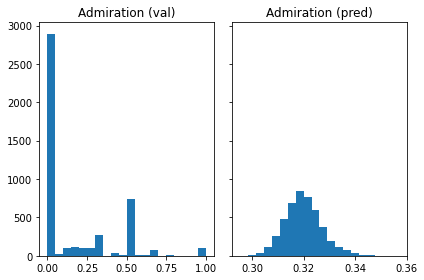

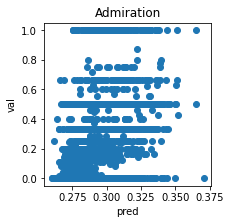

<Figure size 216x216 with 0 Axes>

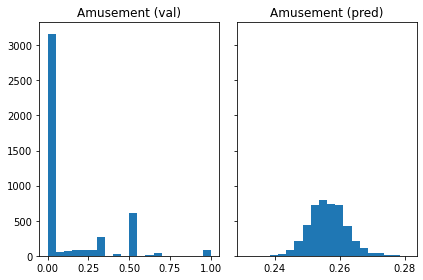

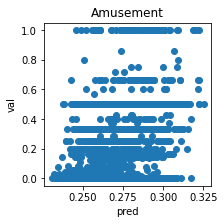

<Figure size 216x216 with 0 Axes>

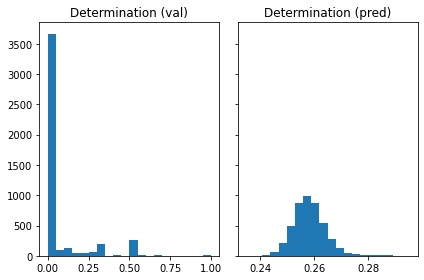

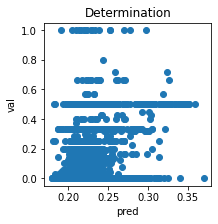

<Figure size 216x216 with 0 Axes>

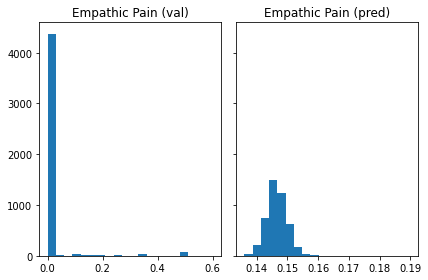

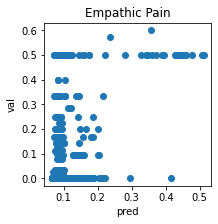

<Figure size 216x216 with 0 Axes>

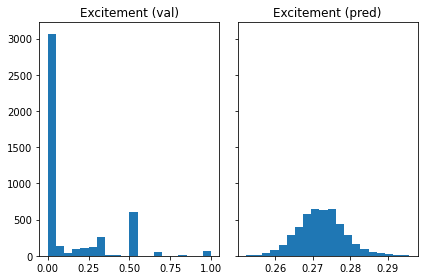

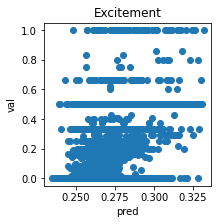

<Figure size 216x216 with 0 Axes>

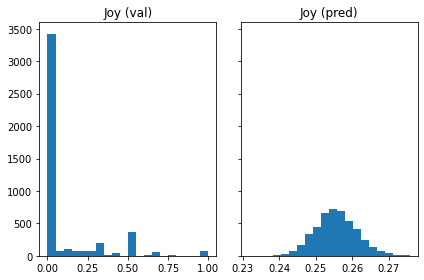

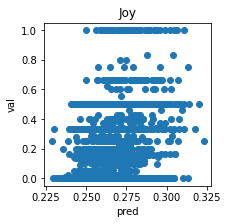

In [58]:
for i, cls in enumerate(classes):
    plt.figure(figsize=(3, 3))
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    axs[0].hist(y_val[:,i], bins=20)
    axs[0].set_title(cls+' (val)')
    axs[1].hist(y_val_preds[:,i], bins=20)
    axs[1].set_title(cls+' (pred)')

    plt.figure(figsize=(3, 3))
    plt.scatter(y_ensemble[:,i],y_val[:,i])
    plt.xlabel('pred')
    plt.ylabel('val')
    plt.title(cls)

ensemble
audio agg features+ 
emi_mbf_va_face_images
mbf_va agg features: (0.28981449809217746, array([0.30411956, 0.30041602, 0.25837018, 0.3147965 , 0.31599936,
       0.24518537]))
       
#mbf va
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

#y_ensemble[:,2]=y_val_preds_audio[:,2]
#y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]
#(0.29894266463043945, array([0.30411956, 0.30041602, 0.25837018, 0.3147965 , 0.31599936,       0.29995437]))



+mobilevit:
0.1 (0.2828523451828629, array([0.30110888, 0.29684512, 0.25949711, 0.30738044, 0.31708184,
       0.21520069]))
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.5
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]
#(0.2981795621039914, array([0.30110888, 0.29684512, 0.25949711, 0.31087313, 0.31708184, 0.3036713 ]))


ddamfn_va
0.1 (0.28359835070967354, array([0.3022263 , 0.29957365, 0.23646923, 0.30028883, 0.31403546,
       0.24899663]))
#ddamfnet
w=0.1
y_ensemble=w*y_val_preds+(1-w)*y_val_preds_audio

y_ensemble[:,2]=y_val_preds_audio[:,2]
y_ensemble[:,3]=y_val_preds_audio[:,3]

w=0.4
y_ensemble[:,-1]=w*y_val_preds[:,-1]+(1-w)*y_val_preds_audio[:,-1]

print(mean_pearsons(y_ensemble,y_val))
#(0.2952040356818089, array([0.3022263 , 0.29957365, 0.2457414 , 0.31087313, 0.31403546, 0.29877427]))

# Save test results 

In [45]:
OUTDIR=os.path.join(DATA_DIR,'test_data','outputs')
print(OUTDIR)
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

/home/HDD6TB/datasets/emotions/ABAW/ABAW_8/EMI/test_data/outputs


In [46]:
def get_test_video_features(videoname2features,stat=False):
    X=[]
    for videoname in videoname2features:
        features=videoname2features[videoname]

        mean_features=features.mean(axis=0)
        std_features=features.std(axis=0)
        min_features=features.min(axis=0)
        max_features=features.max(axis=0)
        if stat:
            aggregated_feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)
        else:
            aggregated_feature=mean_features

        X.append(aggregated_feature)
    X=np.array(X)
    print(X.shape)
    return X

In [137]:
#mlpModelFace.load_weights('test_mbf_va_face_images.h5') 
mlpModelFace.load_weights('test_mobilevit_va_face_images.h5') 

X_test=get_test_video_features(videoname2scores_test, True)
y_test_video_preds=mlpModelFace.predict(X_test,verbose=0)
print(y_test_preds.shape)

(4586, 40)
(4586, 6)


In [55]:
mlpModelAudio.load_weights('test_audio_hubert.h5') 

X_audio_test=get_test_video_features(videoname2audio_features_test)
y_test_audio_preds=mlpModelAudio.predict(X_audio_test,verbose=0)
print(y_test_audio_preds.shape)

(4586, 1024)
(4586, 6)


In [148]:
#mlpModelText.load_weights('test_emi_text_roberta.h5') 
mlpModelText.load_weights('test_emi_text_openai.h5') 
#mlpModelText.load_weights('test_emi_text_gigachat.h5') 

X_text_test=get_test_video_features(videoname2text_features_test)
y_test_text_preds=mlpModelText.predict(X_text_test,verbose=0)
print(y_test_text_preds.shape)

(4586, 1536)
(4586, 6)


In [149]:
if False:
    name='mobilevit_hubert_roberta'
    best_w1=np.array([0.,   0.05, 0.05, 0.05, 0.05, 0.1 ])
    best_w2=np.array([0.8,  0.9,  0.7,  0.4,  0.85, 0.8 ])
elif True:
    name='mobilevit_hubert_openai'
    best_w1=np.array([0.,   0.05, 0.,   0.,   0.05, 0.05 ])
    best_w2=np.array([0.2,  0.2,  0.35, 0.3,  0.35, 0.35])
elif True:
    name='mobilevit_hubert_gigachat'
    best_w1=np.array([0.05, 0.05, 0.05, 0.,   0.1,  0.1 ])
    best_w2=np.array([0.75, 0.8,  0.65, 0.4,  0.6,  0.7])
elif False:
    name='mbf_hubert_roberta'
    best_w1=np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.1 ])
    best_w2=np.array([0.75, 0.85, 0.75, 0.5,  0.8,  0.75])
elif False:
    name='mbf_hubert_openai'
    best_w1=np.array([0.,   0.05, 0.,   0.,   0.05, 0.05 ])
    best_w2=np.array([0.2,  0.05, 0.35, 0.3,  0.2,  0.25])
elif False:
    name='mbf_hubert_gigachat'
    best_w1=np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.1 ])
    best_w2=np.array([0.75, 0.75, 0.7,  0.3,  0.7,  0.65])

y_ensemble=np.zeros_like(y_test_video_preds)
for i in range(num_classes):
    y_ensemble[:,i]=best_w1[i]*y_test_video_preds[:,i]+best_w2[i]*y_test_audio_preds[:,i]+(1-best_w1[i]-best_w2[i])*y_test_text_preds[:,i]

with open(os.path.join(OUTDIR,name+'_train_val.txt'), 'w') as f:
    f.write('Filename,Admiration,Amusement,Determination,Empathic Pain,Excitement,Joy\n')
    for videoname,y in zip(videoname2scores_test,y_ensemble):
        f.write(videoname+','+','.join(map(str,y))+'\n')